In [ ]:
import sys
import os
import glob
import time as timelib
from datetime import datetime
import re
import io

import boto3
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from xarray import open_mfdataset
from netCDF4 import MFDataset, num2date
from matplotlib import image
import base64


from cloudflow.services.S3Storage import S3Storage
from cloudflow.job.Plotting import Plotting
from cloudflow.utils import romsUtil as utils

#DEBUG = False
DEBUG = True

rps_logo=b'iVBORw0KGgoAAAANSUhEUgAAAZQAAAB9CAMAAACyJ2VsAAAAnFBMVEX///9xA0r///1WWWByAUxaXmVQVFtiADf89vtrAEdwAEb39/hkADvz6vFuE05gY2pYAC6EOWZlAD/38Pbt4emWmJvw8PHn5+iChIfV1ddmaG61triMj5FjADTv3OnIyct3I1htcHW/wMPJqcCfcI+kpqlGSU+2jaZsAD2ESGyZZIR7Ll6rhJ/axtatf5zjz9/Rt8m+mrKVWH+PTnnLF5AAAAAQk0lEQVR4nO2dC5uaPBOGY2LiCm7ZugXBQ63ust2eD+///2/fTBIOooQIsdCvPNfVriLEJDeTyWGIhFiIUgr/bM4sLtH/bBInVH7DbdQyYVrJ/vXJFDVQTcuFstRvVHH2+E6vsa0nan/q+XeU35UP0NrKoOW/NDs5O+asClVCd1fLNnlyffLXVHPr7Heov8uXnuQ5ivz26YPuf37978NkfqW8Z0ssmPyX65J/8/ubfZ21y/78czX7cXyIsteb+HDMXm8P++xlGh/87AV87h/iVP6PF2J+5Xt4sQoDIVhxnbWoQnv39Ha3ePW8yZWaThe/G74AswnJzxbLq5P3dp8bGz358SOm/3p17kGQfXryFWvO0izlgLONPrwS/JAZwZYxH69JhcBTfcFC+J9xHqsz5HtK9oJzgMJFei0U+eWPX9uVCDV9uDNUnGpUvi6X83apv35uRALZ/w7Apy3zv3g8zf46CLh+uWdBDiXlgUj0iWHA0FJCxQSgcAklCIQyCvkeMAYsTKJ9ELxcayuI9teiZZVJ7R5NdzOk/2vx2jrx6e5nc/Zn7dOX2acVKEy3WTEvoPCA861+raBIJvQEChynOZSYi41iFkbkOlHy7suiQ5lUqQzJ37+dwUlt7dCbv7XIflsrAU1nlewDlOAgX8GtnkM5sgAchF+CAkz0ZzmUg+Ym38PVsf78WiKUfJt1MRNQtVTl1CH59g2LqrTloyH7hPxczDulj83XGRRoqIhssRQUKMaBhZHInE3IGUlZbkQZFJ6GXDZg8v2GsT25vpsuz3966FSkiYJS25t/mk3bGklWafeGEpCnXWsjLGX/FEp84PIe5zxUjp6SRAAnaM3UqWEQhNBYZVfkUELCeOBrKADo2larKNS0a63VWwoyad9yaZmgYPY7Jn8OhW33TKzQzfNVZg4hO+ABpjw2QOEskI6jAmUvX8r/wKWoT6+mAjdaZxmaL7STrpVmgoLZ79j4XrIUIis8Zim0WNpXy79MWRBCEUeo9OQMCpFHy1CSFyHEi2UbJueiXDC5DEX2/bs3jZNaKLLpnXVzJ1LnlhKDPxD+SojVSkPZMNkHTjlakHT0RxKJrAErQ4H/1wrKNoDmiyIUnvexm5lI4+9eqDqfAsgfpl1v40m9pbjwV1n2q1B8aLZS+KuaLwoDysMRlHLVZKku8VGOEStQ4Ch4InyVcmzsqL+KQmYLxZWd1FmKZDLp1vOSqm2+3NxS51CwjUrZeg3tkLaURAQwNBcM3LgaNao/WQN2AgWOctn6JdgllpOUqS0Ud4W6bCnSx88d3Mi1UJy0XZMaKBH48TXJoGx5sJWKuRxXaigRQDqHApeqPsA6G+SAgVngcOdPLpVK+5OZ/LA7lgtQlD/pMmQs6SIUojrDCkokeDZ7xeS4Ej70sRL32IBRegKFQgOmoCQ4zQI+KAptoDj0J5dKRXRX24E/QV2yFEi/2yxESafZpxoK4PAzKClT/h0+DGWLJaGgYhwsnkKRR9WrDU5IMob/W0BRdnI7KJKJAyORuth8ob9ypGr2uZD93ljOKb7gVAqDI/oU6EvBp1uhJlwodAjglf8ittiICQ0lkq/giiQGJkyIg900MTbIjirt3Ke48yeoS1AwfUfJ1w+zTnTxlObromSfrJqHj5S49CdnpcrGJ3gju8FSgZL7k5sZenlxl1ZXsSkl1VgDWvoor+HrpPyJowLlpTrJo9vkq5bi0p+g7CzlpqJ6vutmpaIOuxBSZ83X08Jp+gOAQqSddJ6Qqi2VW3+CqkLRfW1nGgAU143LWalkt87lrVyBIpm4mF7J1DMU5YRdM8lL5b4LIZVDcbT8U1UVCoXR3lqIQK/hUpJsuRDrNJKnJfE21ceha7yN4aSNHOyHqZozTrfbIi0/3mbCoShee5IIcT4+KZdK91hc+xNUAcXZHOeJzixlLziMLpicEaa4FM8ZTnupoIhE6Jli/TrCtRZ5PhMBfhAzVqSHES5MfQhDf7JlarLswPI0UN8c+5NyqahE7tSfoMrN1zfndnIOJRGBCJMkFXryEep1kyShUGvESWlxa8sDJqEEm80mPcDA3acwnD+BEhxCpY16uya43s/Ko8l7x05SqgicuIGdlKHQd0tI/xaGXtQQTrMom9i/BIlEtJaDP6CBkBIMJFKjQR/jKhCKmpbU02UVKHxbTlvi0Gjyg29d38YoCUWP6W6gkqXcIPvedPd4Yih7OYWFh2ScUbG+qCIlEIqe/N2wAgpVdhAqKEWNn0CRyTE/zJNUd/LiFlAe7jIf37K9NzeoBRT3nQjU7PEkQhLu91J77wu9Aizv+lg1X3rFcR3wEhSKq8VVKH4VygrSwzik4gvvrINxpraCM191ZOnP3cRyTUtedpKKSRoKpXdL59mfyuyfWMohKDU/wCAPJCJxIPAAhrhg+5bgEmO5+VLnmqHgglegYl61Pi7tDMWbPdhrpyKk6ePOdrLLW5ymsDQbWAaFfHy1s8TlNdl/eCanU1UYiVe8zwNYcNqeQV8Laj6JMaoYulLbYwlKdOSBiGgVilyyFOIlyVIB6OUg1jvLxmX2/b3t8w36ixRxu9TPkr/7+Wq0gKz5urNre6ezr++vyX115BgE+Ty98sxlKCuEsk+wZ+sLkWyYhoL1Dp3mIzmHEsgecQaFRDzgRdeLkp8WfnjuzSfXlSlL/ZNdlU0WP84uNWdMQYGzLKYhvel83ib7Ja2D4LT5OmavY+x2IRS5DrZha5JDgYGMYLGs+GrzFSd7VBaXhyv4eaA4/PndXG1gS/N31888y46dJZP3F5YpjUaWQfndbOhTmf1ukyZxUA5sjEQ+KgEbWhMFBewnOgCtHMpqtSpq3eRT9oKlAT/kJbdpvbzJ/L4NE1soyOSCmpsvyL7NfP0cb6luAk+8KVXBIdArv+jiUw2FBFyG2uVQSteboXC+RqSbrNZ+WJWqHROQFRRkUo18gbfma5RP+WbT+Eoz72YpkcB+LiZywKo7ymqFt/46wLkRBQWGKEjoMpRSlER18JjKeZaD/AZ56KnJE8+VnbRUM5TpZTuhNpZCyC9zd0D5k/bZL3ITQqcV6j2K+Qu6kwNnW6j55KAe8JJQKDhwJFRAKW4EgJJo+cqn5O/kKAVnOLPBDyXPZpeC3c0uhbKwlOX7S7exFZTG7KPm907m4GMW4PwjV3EQfoCv8YC85xUUguGTdVBUfwt6XCvZJS7egYmISMfE7FXR/2sYRniqUG3L1QxFtl3nF1pCaezdzT11YnelOCusH52DdiuUISn8qGbdX+SzcpHs46YvLwjlRZShiEwI5aX8Dk5XvWHoTsv5M0o+NFXavFOhGqEs3unHiCqyhPKlKfedbqlyfjA26HgsTU/5yXGfZKEUke/j18ipGB9fEz8qj9D9XJE6O3tH4Y1+ehhO0k9yvzGUCPuSk24NchOURV2/yNKnfGiwlO79rj5kgoIF7ugkjVA86U8uX+gACn70ru+F9lYyQ9nhQLtLucyWMvtRm7oLS5nOuma/J5mgTObPXctktpTPl/0JygWUeXVasYMuZ/KSKyzmyGjbLzdCef3WLtFCRihLw8PwLqAsOmffKFON53GUrWSEMuvsJo1QLs+uKFmO6A1Q5t7OlZeH6k3DMF9WpzpMJwyzeGDod4Vrxg74jIMP55DshLAuSaP6hDK7KZTJZNd9KK8zQ0k29pOx9soE9riPgbaGI45h8NOj3JvlqA+KTV2SRg0VCmmYa/yjUAg+NLSOldIMRIwTxOp1JIL1frU6rhmMG30YvcujOM/YSkNtvgh5Mm6tYgNl5hRKXDmC24FksQ5HppbwfQzDy4KFNkxcv32U1FCh0DvTlUOAEvJ4nc32bhBK4dcPGOvlc35o2f0aKhTyyRwQ0TsUn7Fjmu3psS9meFEJPvUoJ+T/v6B8WppnSnuGItfp/RVulkPVx5ylUf4hxoXxasiKvQYIBUv5qWmvrj8OJUDx3ItAEyXDufRKVnTA2OI4+xD8Dce1lVsMHnuzlOZ4ix6gnASgyA2MSrFGZB/j6kqsp4ZDGVzcdvQ4QCgU267hQZFbfhyPOlByq+IcglKrFm147ttxHav9hqoDhEI+WQRz9OxTIsZDXM3dBuXHF/wixngdHEhrDQyK9CcWsWJTm6l7p4NHFheTWbjwq4IcebmVomQlg15Qwd8K5dKI3vIZgByKyaiMG7VdqYqlgNNfS+lHIFaRXILMdgL7iy3lDAreipYxlRbLwdNd/T6TVwugrIoAlCR38CpcayPWstna/v3N1wVLuQd/YmcpWOH40HH92YuGzYuv0roIQEl0GJdcnfc5RkimgovDFo6yLOT4r4XiPT+e7jD//pfdY3gw1ldb4FLy683kzUVNJs93hi6pXIBq2Kq/fDkXLAtAScgqC0Ah+PAjBrLs10ISC7OrmGg5GYnqEYoHrnhZ1sJ6e2dvptfHjCMB8yoUJc+vyxotPmfPoWVaFfJJtCp2VvF1wHByTDf7qHx+i+rS6tNSKs/x2O/a4i2fZerlxdczUWNsEXzyFfd8vfjIkDd5re51X0n4JKH6r2ipXqG0fWZ49lwqtvw1E1o6kB0jDfXyZl73/OoUfdbptcW7yipveZccVz+Q0q+ltBBwXDzn6VN68RdmaM1xy6LDdzyUe260SLLGTNyGzPx1UCQTB7ckbSh6n9uA/HVQpmgnI5Qucg8F/ImT2hqhuNPCEZMRijs5YzJCcSVX/gQ1QnEkV/4ENUJxI3dtFxmhuJDn1k5GKG7k0J+gRijd5bkZxxcaoXSXU3+CosS4pdYIpUFeMS/sUPfGqP4RSqNct11yzdK4ojZCsWHiorCFKLk3L+aMUBrkti+s9PjFHPE3QjHoJv6EAhPPvPrsMjzpag0dymQ66/zceEWQ2GPTThXyp8970+ChOB4zSiETr2F/6bvWT8F319Ch3MSfSDsx+5Qv9dEst9fAoSxc+xOq/EmDvPnnHv38wKHMXI9P0J98sQj5855cfuu1GjIUl2taWhb9Lslk13HL3G4aMhTn/S5CVNvlNT2V5L1x/LXXqdcAb8P285Op9/C1yUyMYasXdd/YF1Y5+9qhzN3Va4D366Iuwnq5fPP5h0WFU3J3b68f33eWm7D3u6Fer5bScD/aMHneLaw1my3tfq3Nc/lkSwv1CGU6e298WKHZxVPy8bpf3LT8JcuH2l0U/4wG9iBqVU1188XZbx2X9Pq9500OBw6lSXZ++1r1OcWCGqGcqfNupp01QjmVN5k99UuEjFDOM/UR0+0XywilUuSPnfPUXSOUQlMPmfTs5FEjlEJzbLt6J0JGKGVNse1qfoD19hqhKGE6g/AnqBGK0mD8CWqEouQNxZ+gRihZWT9azYH+EY1Q1A9OD8afoEYouT8ZiJmQEYrOyXD8CWqEMhmWP0H981AyfzJCGRAUT9lJ55y41D8PRY0Zh6V/Hsrw7GSEMjh/gvrHoSwMv2rYn/5pKMsPPQd41eivhkI7QfH01MrQsFBieoBm+tB5B/9PhmA5B8kbs28oGG5tvPh+j1P1A3MnRG4Wv6t/LOC16+NMlPzc1VfN0kHE7tPD9Ui81+Vi+empzydNm/T04fJe8aDvd11vI9qQfNfMG9Ov05fPH785/BGPG+jGxmvei747lC4pDK7d0pL7wddl7rZ11rztuUX6La9RO3J3++6b6X/PkWWaG0eBDQAAAABJRU5ErkJggg=='
ioos_logo=b'iVBORw0KGgoAAAANSUhEUgAAAUAAAAB9CAMAAADk3UpfAAACiFBMVEX//////8z//5n//2b//zP//wD/zP//zMz/zJn/zGb/zDP/zAD/mf//mcz/mZn/mWb/mTP/mQD/Zv//Zsz/Zpn/Zmb/ZjP/ZgD/M///M8z/M5n/M2b/MzP/MwD/AP//AMz/AJn/AGb/ADP/AADM///M/8zM/5nM/2bM/zPM/wDMzP/MzMzMzJnMzGbMzDPMzADMmf/MmczMmZnMmWbMmTPMmQDMZv/MZszMZpnMZmbMZjPMZgDMM//MM8zMM5nMM2bMMzPMMwDMAP/MAMzMAJnMAGbMADPMAACZ//+Z/8yZ/5mZ/2aZ/zOZ/wCZzP+ZzMyZzJmZzGaZzDOZzACZmf+ZmcyZmZmZmWaZmTOZmQCZZv+ZZsyZZpmZZmaZZjOZZgCZM/+ZM8yZM5mZM2aZMzOZMwCZAP+ZAMyZAJmZAGaZADOZAABm//9m/8xm/5lm/2Zm/zNm/wBmzP9mzMxmzJlmzGZmzDNmzABmmf9mmcxmmZlmmWZmmTNmmQBmZv9mZsxmZplmZmZmZjNmZgBmM/9mM8xmM5lmM2ZmMzNmMwBmAP9mAMxmAJlmAGZmADNmAAAz//8z/8wz/5kz/2Yz/zMz/wAzzP8zzMwzzJkzzGYzzDMzzAAzmf8zmcwzmZkzmWYzmTMzmQAzZv8zZswzZpkzZmYzZjMzZgAzM/8zM8wzM5kzM2YzMzMzMwAzAP8zAMwzAJkzAGYzADMzAAAA//8A/8wA/5kA/2YA/zMA/wAAzP8AzMwAzJkAzGYAzDMAzAAAmf8AmcwAmZkAmWYAmTMAmQAAZv8AZswAZpkAZmYAZjMAZgAAM/8AM8wAM5kAM2YAMzMAMwAAAP8AAMwAAJkAAGYAADMAAAALihLaAAAACXBIWXMAAAsTAAALEwEAmpwYAAAMK2lUWHRYTUw6Y29tLmFkb2JlLnhtcAAAAAAAPD94cGFja2V0IGJlZ2luPSLvu78iIGlkPSJXNU0wTXBDZWhpSHpyZVN6TlRjemtjOWQiPz4gPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iQWRvYmUgWE1QIENvcmUgNi4wLWMwMDIgNzkuMTY0NDYwLCAyMDIwLzA1LzEyLTE2OjA0OjE3ICAgICAgICAiPiA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPiA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIiB4bWxuczpkYz0iaHR0cDovL3B1cmwub3JnL2RjL2VsZW1lbnRzLzEuMS8iIHhtbG5zOnhtcD0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wLyIgeG1sbnM6eG1wTU09Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9tbS8iIHhtbG5zOnN0UmVmPSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvc1R5cGUvUmVzb3VyY2VSZWYjIiB4bWxuczpzdEV2dD0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wL3NUeXBlL1Jlc291cmNlRXZlbnQjIiB4bWxuczppbGx1c3RyYXRvcj0iaHR0cDovL25zLmFkb2JlLmNvbS9pbGx1c3RyYXRvci8xLjAvIiB4bWxuczpwZGY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vcGRmLzEuMy8iIHhtbG5zOnBob3Rvc2hvcD0iaHR0cDovL25zLmFkb2JlLmNvbS9waG90b3Nob3AvMS4wLyIgeG1sbnM6dGlmZj0iaHR0cDovL25zLmFkb2JlLmNvbS90aWZmLzEuMC8iIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIiBkYzpmb3JtYXQ9ImltYWdlL3BuZyIgeG1wOk1ldGFkYXRhRGF0ZT0iMjAyMC0wOS0wMVQxODoxODowNy0wNDowMCIgeG1wOk1vZGlmeURhdGU9IjIwMjAtMDktMDFUMTg6MTg6MDctMDQ6MDAiIHhtcDpDcmVhdGVEYXRlPSIyMDE1LTA1LTI5VDA5OjQ1OjEyLTA0OjAwIiB4bXA6Q3JlYXRvclRvb2w9IkFkb2JlIElsbHVzdHJhdG9yIENTNiAoTWFjaW50b3NoKSIgeG1wTU06SW5zdGFuY2VJRD0ieG1wLmlpZDo4YzgzYmVhMi1jOGNiLTQ2MDItOTU4Ny1hMWQ1ZTczMzY0ZmYiIHhtcE1NOkRvY3VtZW50SUQ9InhtcC5kaWQ6RUZBQ0FDMTQwMTM2NjgxMTgyMkFCNzkwQjczNjY4QTEiIHhtcE1NOk9yaWdpbmFsRG9jdW1lbnRJRD0idXVpZDo1RDIwODkyNDkzQkZEQjExOTE0QTg1OTBEMzE1MDhDOCIgeG1wTU06UmVuZGl0aW9uQ2xhc3M9InByb29mOnBkZiIgaWxsdXN0cmF0b3I6U3RhcnR1cFByb2ZpbGU9IlByaW50IiBwZGY6UHJvZHVjZXI9IkFkb2JlIFBERiBsaWJyYXJ5IDEwLjAxIiBwaG90b3Nob3A6Q29sb3JNb2RlPSIyIiBwaG90b3Nob3A6SUNDUHJvZmlsZT0ic1JHQiBJRUM2MTk2Ni0yLjEiIHRpZmY6SW1hZ2VXaWR0aD0iNzAxIiB0aWZmOkltYWdlTGVuZ3RoPSIyNzQiIHRpZmY6UGhvdG9tZXRyaWNJbnRlcnByZXRhdGlvbj0iMiIgdGlmZjpTYW1wbGVzUGVyUGl4ZWw9IjMiIHRpZmY6WFJlc29sdXRpb249IjE0NC8xIiB0aWZmOllSZXNvbHV0aW9uPSIxNDQvMSIgdGlmZjpSZXNvbHV0aW9uVW5pdD0iMiIgZXhpZjpFeGlmVmVyc2lvbj0iMDIzMSIgZXhpZjpDb2xvclNwYWNlPSIxIiBleGlmOlBpeGVsWERpbWVuc2lvbj0iNzAxIiBleGlmOlBpeGVsWURpbWVuc2lvbj0iMjc0Ij4gPGRjOnRpdGxlPiA8cmRmOkFsdD4gPHJkZjpsaSB4bWw6bGFuZz0ieC1kZWZhdWx0Ij5JT09TX0VtYmxlbV9QcmltYXJ5X0FfUE1TPC9yZGY6bGk+IDwvcmRmOkFsdD4gPC9kYzp0aXRsZT4gPHhtcE1NOkRlcml2ZWRGcm9tIHN0UmVmOmluc3RhbmNlSUQ9InhtcC5paWQ6RUZBQ0FDMTQwMTM2NjgxMTgyMkFCNzkwQjczNjY4QTEiIHN0UmVmOmRvY3VtZW50SUQ9InhtcC5kaWQ6RUZBQ0FDMTQwMTM2NjgxMTgyMkFCNzkwQjczNjY4QTEiIHN0UmVmOm9yaWdpbmFsRG9jdW1lbnRJRD0idXVpZDo1RDIwODkyNDkzQkZEQjExOTE0QTg1OTBEMzE1MDhDOCIgc3RSZWY6cmVuZGl0aW9uQ2xhc3M9InByb29mOnBkZiIvPiA8eG1wTU06SGlzdG9yeT4gPHJkZjpTZXE+IDxyZGY6bGkgc3RFdnQ6YWN0aW9uPSJzYXZlZCIgc3RFdnQ6aW5zdGFuY2VJRD0ieG1wLmlpZDpGQ0Q1QzgwQjc3MzQ2ODExODIyQUI3OTBCNzM2NjhBMSIgc3RFdnQ6d2hlbj0iMjAxNS0wNS0yOVQwODozNTowMi0wNDowMCIgc3RFdnQ6c29mdHdhcmVBZ2VudD0iQWRvYmUgSWxsdXN0cmF0b3IgQ1M2IChNYWNpbnRvc2gpIiBzdEV2dDpjaGFuZ2VkPSIvIi8+IDxyZGY6bGkgc3RFdnQ6YWN0aW9uPSJzYXZlZCIgc3RFdnQ6aW5zdGFuY2VJRD0ieG1wLmlpZDpFRkFDQUMxNDAxMzY2ODExODIyQUI3OTBCNzM2NjhBMSIgc3RFdnQ6d2hlbj0iMjAxNS0wNS0yOVQwOTo0NToxMi0wNDowMCIgc3RFdnQ6c29mdHdhcmVBZ2VudD0iQWRvYmUgSWxsdXN0cmF0b3IgQ1M2IChNYWNpbnRvc2gpIiBzdEV2dDpjaGFuZ2VkPSIvIi8+IDxyZGY6bGkgc3RFdnQ6YWN0aW9uPSJkZXJpdmVkIiBzdEV2dDpwYXJhbWV0ZXJzPSJjb252ZXJ0ZWQgZnJvbSBpbWFnZS9qcGVnIHRvIGltYWdlL3BuZyIvPiA8cmRmOmxpIHN0RXZ0OmFjdGlvbj0ic2F2ZWQiIHN0RXZ0Omluc3RhbmNlSUQ9InhtcC5paWQ6YjY2YWFlZjktYmVmNS00NzA4LTgwMWItODcxMmVkODk3N2I3IiBzdEV2dDp3aGVuPSIyMDIwLTA5LTAxVDE4OjE3OjE4LTA0OjAwIiBzdEV2dDpzb2Z0d2FyZUFnZW50PSJBZG9iZSBQaG90b3Nob3AgMjEuMiAoTWFjaW50b3NoKSIgc3RFdnQ6Y2hhbmdlZD0iLyIvPiA8cmRmOmxpIHN0RXZ0OmFjdGlvbj0ic2F2ZWQiIHN0RXZ0Omluc3RhbmNlSUQ9InhtcC5paWQ6OGM4M2JlYTItYzhjYi00NjAyLTk1ODctYTFkNWU3MzM2NGZmIiBzdEV2dDp3aGVuPSIyMDIwLTA5LTAxVDE4OjE4OjA3LTA0OjAwIiBzdEV2dDpzb2Z0d2FyZUFnZW50PSJBZG9iZSBQaG90b3Nob3AgMjEuMiAoTWFjaW50b3NoKSIgc3RFdnQ6Y2hhbmdlZD0iLyIvPiA8L3JkZjpTZXE+IDwveG1wTU06SGlzdG9yeT4gPHRpZmY6Qml0c1BlclNhbXBsZT4gPHJkZjpTZXE+IDxyZGY6bGk+ODwvcmRmOmxpPiA8cmRmOmxpPjg8L3JkZjpsaT4gPHJkZjpsaT44PC9yZGY6bGk+IDwvcmRmOlNlcT4gPC90aWZmOkJpdHNQZXJTYW1wbGU+IDwvcmRmOkRlc2NyaXB0aW9uPiA8L3JkZjpSREY+IDwveDp4bXBtZXRhPiA8P3hwYWNrZXQgZW5kPSJyIj8+bXSAtgAAEyVJREFUeNrtXTui27jOVpV/I5qG2sthxZWo4mmsXbhSmstKuyAbswIaYT9/wfdDspxMca99nMlMTsaSKBD48AaH4aXPyPg8r6vR/te6zjNn4/DzufBhs1yNMdZE8mn3ozHrnbMfAp1yHl+1McZoo7VO9NP+Y6wx+s5/OPGQesYaY3TgOm20iSxojDFGa22MNSv/oVYruXdjjWM7z3Wmw4KehkavP2xYfLg2Vnuu8zxntTXpV+DASEL7w4Y5+awx2iQGtMZq/Xtd73KeZ3lf11U/zMM8IgMarY3RPyTMyKc9UYx9GC3nr6mU0X9GPq/aPIwNTGq0/SHhMAxsTWxlrDV6PtGyI5faWB0l3ZiPx8K7iQpXW6Pnr6dXfM3mYU0gojXyk8n3lSRSW7N+XRX61V3nCf+5cny3JqmN+RVhHGdtg4ljzfyh6OcsF220sfplGoyztsFMtPoTkZBH8LN6/hMCjLMNJrexnyfGs9XOdrFm/dMIwbjaR7AfP02M16AFrPn6Kza23m+262fRL3hs9v4vKCJ3sw+i4BiMYXtqgowTmzgXE5vGc0fG3+xjjOpxjZ7EEfpNQqoNAIF2BATYlBTT0XeDOv4Ut2T87VjGHMDWKBYAJEJAQAAAQEAkAljEKaBq+/tT8M9obbTtKk6hgALhPPHA/YhACIr3VXpInnwK/Yw2PfqNEogAHM0wEC/9C5AI5AkF/1on/Y/Yf336sRsSBvJB+lNgQP9fwtt4TMF3twf5Mf2kI1+kHxLtREBERIQ5LQnlMQXf2ydhh/LLgTLIIwLYlJSCC8GlVAp2okyaaeN91jbavHPmczQ+9tLQT1GCPCJYRG37TVIBUZJmWo7AYf0AAKzfcXLsB4AABLcjKeSLpyECAMHUWDPu7vLdAbCJPkmvehGQQJyysLCRhEj1V31wzPC3FWDvMVQotVDAPtrE07sIoKBoqOK1yesR/aYElH1LQwVke8J9uboOFFR9Fn9PW+arD4AqiC+pq64s8zTHhoIBBt9SE68uZmLGlv8QgFC8cC+BLshQU3D0KPiOmph7BOQt/wEAba8xDQMKfNsV4jfUIy6NVkVgFvLKV718P0XenLn1XO31HRlQG21KAZY+clAR4donKO/Smhntv2jKTFxIuSxSisNo5LHNMYlwMb98MeNCyuXmnljKpHkYUxu5PODf98kSpBAHEenFx71wap3ibqxxklL0/ukSe5IKnCMOREgASl4nIr8pAELyvjyAEk8hiokF0Dv+REgIoGS8jPsgYJ7BHDcHgK1X5pdA/n4AW/cll92pYijWoQ9ZcKP+B9qXkUDBcfQ+EhLtIK8g9XTzJIcUSSJCdaolJ4XF8/wjCWER4zAM3tE3xho5lgDYwT+2ABGVd4Jv1sNBBKx24JgFqwWmmC2rH48EVVjSrwOXZyScFISoUhHKhINQZjDM9uJ5KaaMRCiGwXoG1Fobe2fDMAzC89/W3g3zJYQ7ESrW8pT7Xzm7jZ4FOxxYrC/71Rrq/rnpd1hHL5RW7OlOgWoZA/rfR66CQMqidXkw3oXv1DBwV3bv6kytuX8Ng/8G1gDHMAW2ylsR1hScPAWKTZBWm266WdEFDnSBjZp++SpgOvMzswhw4sD4Q9dbkITF10u2B9zVEMqBtK++t+bulWgTERgElU/FFJwm3vsyYOkVj0e1NgcMWGCgQAqLz1MJ+Qsdu5yScpbNouiJHTvkD7YI1FsWnhogatY29jAY3bXiIlSFRJwPEPrX2IY+DFZMNB7YMBtCI5gAgNk7SSpzWU5IKjlGkqemab39RX6Hai7glN+dkHYi2pGyp0YtwfUjlmKgu+KIo3cCJTdEANhCLLW3bnZqCbVaeCfKyFhrYUkZmQDQqzKknQqm7BoOYS8D99BOAABEOxUAVwndRlDkHdW3XKRSAGGhhZp1vSBam+69AgjuhEqMfkmkhoEJBUTQ04CCupq0a52p5fa9yC0xhFzkIpN9ISlJHgLhJjljE5uYWEK2NbypPKMfAtKuJGcTmxgXi3X1AREzeLn+hCW5qTlOW7hhsV3s/jBGW3fF1n9R8Pp2AwBA5d/+ALw9T1yPRXxTALOl2YskNwSlxcKXnTJcbOBYUm72gfyn3DrCXCuzElegDwzRW60MvXE12i3zWQQmcuBpZMYrncsEvEVwVhXnZ7bf3tpMk8opWLE8pxzmZIcpKMuJqUzpBwbcm4uUv2BvKbC6pWzPQAuhe3nFgoTwCgsGXZmBcyGDh9gySEr4WFF/21PWFXifG1KpSqKwCIq7wycx1Nwi7oK9kPyBp/GMgAJ78njCgQG1yzVHAUYgPNDjYk8cWNB4oQhxh5E5SZllMqXFeKUtuvzT50DmF1oIdqc/ZAPobk35XYbt3Z5gIHYwcMskmJ/gRVTHWyX9Xi/CeLpzUG638kyJ+9TxarpQE2GrWD/rWb99DBxnbYug/UIvqZFb5CLVakN4ggYyYl3+tSWpUpzOJCoZhKyMyAP2XH3/WXo3Atzzfb73/K8NEKBm4C9jq7wRd7KxvISBgOWdVXQgz7WWitVP6XssORynoc38e0uhabG3a2yRi7x939owytboTWaOEk5YY+BvW+dGf7k1bZcJ2CrDTIv2eKHwlaM9GKVORHTD7YnFkFQxCyLsn/pCUH5qrXlXs1DHoLYeQ7ig/WNuCA0XA55LzKMuHXx6qo0yFvyu1OVzHNmipem/6WOafRY8t9xyHeyzaXqqUbQDobxNvImXQDByIP6n2iv364lPM+0pThBtueg1P382FiaAjJW4uF83xJwxkFGLP7o1Mxv2lPjqgosZgnI8cK8OlEjwF1QlFAdK/8Bni6+QPJinS5gyh9r9RYpcYyfgeZpQyyXYdJORTlpUN0Gaq5FfL6FIDwMTij3nY0lYSt0txif26Tl+RId68p4oJr2Ot0sw1EKbT0Z2lU1rxrQVDoquuCyFFQ+A+5J5TTF29PQVIhcFhlMx9PVcj4lUPyqKaGAg4ZX0U5NKcmVHbRrjgC6+Kr9NjryKgarx24Eu3CR5LGoYhmGMBLiwhdMeL5aeGgUFgQjVk9zVhFghFnMUmbs6qwWluSny8tvILhKwfd8YObqCAyqFFIdhGFgMdF1BYai0yMBD/XJypp/QcNoBS9+POyX8NVzCwFC/wRsv/5odc6MTS/hKjv+WIn+jU0AhRiAuK4AslCEpC+EHX/ksDcobpT0/tNHGjs/B0vsitcpxqRG6RsDvWB23VEGl42h9G1DEmAwQe7RE+CUC+qdvaUMwT2NFPjxKQwsnK6JWwm1Rmtq7wOIgM2dY4R5/kQMjjqvMigmmnLgEop4GwLxe8CG9KwRMhkyT1sQqkXaQQ+XO6BeNGdjhwC4GMm2rMkrHBMRfwsDMF2YxknCFA8Ue2WXKIjRwifoq9cIUiXXKFElK63ZzqHyv7S2vFcaLGOj9Ft4kRq4qkQYDpxTKv8aBAbCYf5/rHLjsUVoLplDoGyvLZG6vbpK754taKzzYNTswWNKZCEu3/msivLQYyGIyaZdXQTQGpUSk/hURUDEqXb0Xu0FVoHAUXGNNFujLdGovj+1AVyxseGPavciBGQamvOxyFUQxGI3BtLvmjcecYMdnFAsQIVRlCs22uIBQDjaeIq/ZgXmzhNdjV5VIg4GhyOYFOzDpAZaySVfswMC+faub32JdWEqiNp4I1VGjgx6jAwxcrdHmYSq5KL3r1zDQheUQAK9EFSPG794TiYbcBU8k6fsji3OSNsJhp/osrjZ/2O9+f0ffDhzbeNYBq575wqW4LjtcCqemyE3Wb7YFFtwv+MJ7JyPQ8qEiyllw7IT5ymiM7RZF9u1AbrXRhRUzIlxIIJ9goMsuXoxrytTpI4JWCvU8/JIOcV8+BRyWJ6HrNd2ozr58mcN4YEuX1RXKZZwy0VVP9MAOTFx1JR64Y+6IxGQnXHAExy3Ze+OzsHNMQtdrEm1W2Dx6vojaO7Duia3rCC1c7TTp+MIB26941FOGTrlZgVfiWSJlDp5ulEiFitAG1KqG1bk7RWbrPWltO459TuRiPLfjCw/DEqvznnHRkiT4VgfDngJAUlYXTJ5bsjf7qrzJytm143hTNyunWRWgO6pUuuQLDwNPuYlzNcKS1xqDF5KS1XaFqY4K+7r2Xq9owFenijLRYZuk0lYhlRNhbWyZFxZ/kBdu7qwI4LBKpQ1HFd9jWSm5fBKKxSL3N6lNKaVUv+h1iwI/dEFwqfzbuQfX2BpXc9Vx53KrxC8TsIOBHrPxQmVCpEFRmRDduemCExm9JkmEO+3U3zR1UAbvXM+YW/Z/x7vJkz5DlLUxfpt+XSTg0sNAV4gTLNfDveDJScjXxfKidHYahChrY4JS6Zvgag/Y2o8qPsXRS/WBXilcr87q2YGFKXgcVkmBl2r1t6zO9Kg6S2TFD4HKMjD9f7pwG/3iHpheyAJ1MfDIPb88OavnC+epju44gdI0awUDUgvFQXHckpVZx92O6VR1vNPdyjPAK0WRBxjY0QmAoM2d/Q0HDqzIL7ZJbhb1DALWVWycsirofelo1MyqSwZDKPbqXDFwjC7icvASB3anCCOycgzk20HVnmteIKuvHlPQ84UbIYa6q2tSsYGpK+SSipakqsBaUVa/n4WZhY8O9mJbsB/3xwTU7Sp9hkS7Eqyo0t8I+1X6wQbzk9DPSMiVUkqpLYWK3F+Imh9CVxd8i4mxcZrEze6Uz6DqLHzJo6FIqKSYGGMTFwpoz/NuGT1kzCUsRX/rJDeKiqmbqw6oy44i5oRKOkxRN9881yP35AHNzebW5mzE/kY77UWkaMeddkrdZpLKTqOddkSA2PZymgBWmZXselAAAePFXeYVlHVVACh1+74tWZNI7rQ0dbkHupPFOuKo2YKu3w5WDQgmDOPXPYMyC3qVo8zcH35lm0dVgyECYNX5ddyphJineKHo2glmeiGPEotEkutNxh3zIWy+/mGuxj37ze73ymVdopjnqI4a6/bvuxsr6qd69wcrZ10gkPcB5vpAAMXeLsgHyGVNNvtxr9xeNitBkS9HAKzSbKKY9gdFg2WgH7BhGGZr65FZIf4xtfoKy+F3wUdtQXAKs8iGgd2teYROPGtN3y4vehej2vy//JYb1Z3CWFCB1LGvwYGqzcGid5Bqm0xiOe2v7a/zFDdt4tJVNvf6hfMRWSnjRXD7p46uBduAD8MwjKsxjzDe+2GOxL0o5ekFfCVSRbhMDE+6podhGMaFqB15CDEJJboSVDRml3wYzKm1M1LIl8p1NPgksyGq6Ceqyucd66P0nXj90THFXMx8n1lnB7Fs6nQE6PbN19YiEDWdsghAvTqDCZBytVbl49J2hcGLnehs3wmbpALc/fTFg4EPqu15H2c/n99emJmwH85MGKXaiQpR3Ilwk1f8bfYNO+GeszkdFwsxIRUQlRcg4I5ENnteJww68EDoAzd24kJIwY8qDmNzRkFceTyW+2hqxzQc7WAi86XBG8XFkE21sMvpxWySt3CB39VmSsjsJ46zVuFez6d1za5SNX/9m5NAGRdSSvnS6Jd8+93FfLp28cS4EPL76Hlrb6qVTy/BH04u6ti0qxtS/YbDs7irQrW8F999eXbWFJLZlfjP/qSgd5zBGAZwjx0K4vPe4SYC01Pho/Po3nOcNPNHScmhjcI5IHxlfmA/feE36U0n+c79uWCKotVzLTOeBuPU6tsXOLzrNG7f3/Go+eOWOs0uDAGVqZSnJrgfUfi+Z7MEa1o3/syefO1TLmQyjR5oqD36k77+6oyc/3YhPpkjHbw2OKzvF2moVq96+PcHjNP3PNK+45KVcxGBktXMQOYnmUe3vMVLP4D2vQ9Xmo5n6W+5+06046ZuUgohpFzUhkCU+fWdkJIMU6rf+1gbD4M9OZOQzV1yI7PcMEcqMhUI1NM1vtXEPN79hLl46EJLwV8yF9LOlLoQ35eHJtL7nyeSHYDUedVfwrqjQ7pj6vxJD6K/LZ9Cv/MzgXyVOkI1zdED49FJD6s15v0VSK0uj071Gvhtc/NvPeuhC6yC6o/bHcbf/nDxDzhRyb2wp+CJxmRcKgUAhDvuAKAWyY/823gy3+ecbTimkzVPdeY4TWxi03k80qvfY4Z+axz8a9QaV6s/kH5JF5u/G9o+m3BQuP2083Fn44FQ//mRmGyNR7vazzsmnIcTkHQ23Pw16TXmXzmk+H/1w6IYa2NePiR8nI3VEf4+8Yz1zP8y2lgzvxKGZ3drsyPah0/9fIWjgbXWF8tLh2EY+JrmeZvzQ54/RpcYp07n58Tgdx3rXz5Te9RIGNSx0cZYbVZ+DGhsXo2xRvv6F23Np6Jf5Yp5Y84T0eh15mysnBI+r8YYRzxvulwX+vcnYRixb7TW2hhrjDHrepd3eZf3dXUHqkXqOdNl/fohXaYWbPJNwrEZxlHSmpxDHQ1/yNfCm46+STi4xf/ga8d1Zjfrmf2QrDVqVmOd8HoGdNwYSsd9zPlx3gvy2Z/xa9ZWW39wS82AD2PtJUvnw4nI59Vxmk0saI21xqwz/5Hci4jI53ldV8+C63qX89dHW3z/D/xKT04VnQ/jAAAAAElFTkSuQmCC'


In [ ]:
def make_indexhtml(indexfile : str, imagelist : list):
    """ Creates a basic index.html file for displaying the images in imagelist """

    htmlhead = '''<html xmlns="http://www.w3.org/1999/xhtml">
                  <meta http-equiv="Cache-control" content="no-cache">
                  <head>
                  <title>Cloud-Sandbot</title>
                  </head>'''

    htmlbody = '<body>\n'
    for image in imagelist:
        imagehtml = f'<img src="{image}">\n'
        htmlbody += imagehtml

    htmlbody += '</body>\n'
    html = f'''{htmlhead}
               {htmlbody}
               </html>'''

    with open(indexfile, 'w') as index:
        index.write(html) 
        

In [ ]:
def roms_nosofs(COMDIR: str, OFS: str, HH: str):
    """Load ROMS NOSOFS dataset"""

    filespec = f'{COMDIR}/nos.{OFS}.fields.f00*.t{HH}z.nc'
    print(f'filespec is: {filespec}')
    return open_mfdataset(filespec, decode_times=False, combine='by_coords')


In [ ]:
def fvcom_nosofs(COMDIR: str, OFS: str, HH: str):
    """Load FVCOM NOSOFS dataset"""

    filespec = f'{COMDIR}/nos.{OFS}.fields.f00*.t{HH}z.nc'
    print(f'filespec is: {filespec}')
    return MFDataset(filespec)


In [ ]:
def dsofs_curr_fcst(COMROT: str='/com/nos'):
    """ Load the currently run OFS forecast on COMROT 
    This is almost the same as dosfs_newest, but will work better
    when running when injected in the regular workflow.
    It depends on a file being present in COMROT 'current.fcst'
    """
    
    cur_file = f'{COMROT}/current.fcst'
    #cur_file = f'{COMROT}/testing.fcst'

    with open(cur_file) as cf:
        fcst = cf.read().rstrip(' \n')
    
    print('fcst: ', fcst)
    
    COMDIR = f'{COMROT}/{fcst}'
    print('COMDIR: ', COMDIR)

    OFS = fcst.split('.')[0]
    fcstdate = fcst.split('.')[-1]
    HH = fcstdate[8:10]
          
    if DEBUG: # Only grab first 0-9 hours. Faster!
        filespec = f'{COMDIR}/nos.{OFS}.fields.f00*.t{HH}z.nc'
    else: # Grab all hours
        filespec = f'{COMDIR}/nos.{OFS}.fields.f*.t{HH}z.nc'
        
    print(f'filespec is: {filespec}')
    if OFS in utils.roms_models:
        return open_mfdataset(filespec, decode_times=False, combine='by_coords')
    elif OFS in utils.fvcom_models:
        return MFDataset(filespec)
    else:
        print(f"ERROR: model not recognized: {OFS}")
        return None

In [ ]:
def plot_roms(ds, variable, s3upload=False) -> str:
    
    if variable == 'zeta':
        da = ds[variable].isel(ocean_time=1)
        cmap = cmocean.cm.phase
    if variable == 'temp':
        da = ds[variable].isel(ocean_time=1, s_rho=0)
        cmap = cmocean.cm.thermal
    if variable == 'salt':
        da = ds[variable].isel(ocean_time=1, s_rho=0)
        cmap = cmocean.cm.haline
    if variable == 'oxygen':
        da = ds[variable].isel(ocean_time=1, s_rho=0)
        cmap = cmocean.cm.oxy
    if variable == 'Pair':
        da = ds[variable].isel(ocean_time=1)
        cmap = cmocean.cm.diff
      
    #fig = plt.figure()
    fig = plt.figure(figsize=(12,5), dpi=72)

    ax = fig.add_axes([0, 0.1, 1, 1], projection=ccrs.PlateCarree())
    im = ax.contourf(da.lon_rho, da.lat_rho, da.values,
                     transform=ccrs.PlateCarree(), 
                     cmap=cmap)
    
    coast_10m = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m',
        edgecolor='k', facecolor='0.8'
    )
    ax.add_feature(coast_10m);

    # TODO: FIX BUG in INIT time: This does not work for ciofs since the first history file is not at hour 00, but at hour 01
    # maybe use this global attribute instead, use the t00z portion of the string
    # :file = "nos.ciofs.fields.forecast.20200828.t00z_0008.nc" ;
    init = ds.ocean_time.isel(ocean_time=0)
    init_str = f"INIT: {num2date(init, init.units)} UTC"
    
    valid = da.ocean_time
    valid_str = f"VALID: {num2date(valid, valid.units)} UTC"
    
    title = ds.title
    ax.set_title(f'{title}\n{init_str}    {valid_str}')

    #cbar = fig.colorbar(im, ax=ax)
    cbar = fig.colorbar(im, ax=ax, pad=0.02)  

    long_name = da.attrs['long_name']
    if variable != 'salt':
        units = da.attrs['units']
        cbar.set_label(f'{long_name} ({units})')
    else:
        cbar.set_label(f'{long_name}')
        
    # Add the forecast date and time to the filename
    init_datetime = num2date(init, init.units)
    fmt = '%Y%m%d_%HZ' #'%Y-%m-%d %H:%M:%S'
    ini_str = f"{init_datetime.strftime(fmt)}"
    
    indexfile = f'docs/index.html'
    outfile = f'docs/{ini_str}_{variable}.png'

    bbox = ax.get_position().bounds

    #img = image.imread('rps_small.png')
    logo1 = io.BytesIO(base64.b64decode(rps_logo))
    logo1 = image.imread(logo1, format='PNG')
    logo1_axis = fig.add_axes([bbox[0], 0.0, 0.1, 0.08])
    logo1_axis.imshow(logo1, interpolation='hanning')
    logo1_axis.axis('off')
    
    
    logo2 = io.BytesIO(base64.b64decode(ioos_logo))
    logo2 = image.imread(logo2, format='PNG')
    logo2_axis = fig.add_axes([bbox[0], 0.0, 0.325, 0.08])
    logo2_axis.imshow(logo2, interpolation='hanning')
    logo2_axis.axis('off')
    
    dst = timelib.localtime( ).tm_isdst > 0
    if dst: tz = 'EDT'
    else: tz = 'EST'   
    
    datestrfmt = '%b %d, %Y %H:%M %Z' #'%Y-%m-%d %H:%M:%S' 
    #https://docs.python.org/3/library/datetime.html#aware-and-naive-objects
    now_str = f"Created {datetime.now().strftime(datestrfmt)} {tz}"
    fig.text(0.70, 0.02, f'{now_str}')
        
    fig.text(0.0, 0.975, 'ROMS')
    
    if not os.path.exists('./docs'):
        os.makedirs('./docs')

    imagename = outfile.split('/')[-1]

    plt.savefig(outfile, bbox_inches='tight')
    #plt.close()
             
    if s3upload:
        s3 = S3Storage()
        bucket = 'ioos-cloud-www'
        bucket_folder = 'sandbot/'

        key = f'{bucket_folder}{imagename}'
        s3.uploadFile(outfile, bucket, key, public=True)

    return imagename

In [308]:
def plot_fvcom(ds, variable, s3upload=False) -> str:

    time = 3
    siglay = 0
    dims = 2
    
    if variable == 'zeta':
        #zeta(time, node)
        dims = 2
        da = ds[variable]
        cmap = cmocean.cm.phase
    if variable == 'temp':
        #temp(time, siglay, node)
        dims = 3
        #da = ds[variable][:][siglay]
        da = ds.variables[variable]
        cmap = cmocean.cm.thermal
    if variable == 'salt':
        #salinity(time, siglay, node)
        dims = 3
        da = ds['salinity']
        cmap = cmocean.cm.haline
    if variable == 'Pair':
        #atmos_press(time, node)
        dims = 2
        da = ds['atmos_press']
        cmap = cmocean.cm.diff
    if variable == 'oxygen':
        return "not supported"
          
    #fig = plt.figure()
    fig = plt.figure(figsize=(12,5), dpi=72)
    #fig = plt.figure(figsize=(12,5), facecolor='black')
    
    ax = fig.add_axes([0, .085, 1, 1], projection=ccrs.PlateCarree())
    
    # Don't add the land mask if it is a Lake forecast
    #if re.search("LEOFS", ds.title) or re.search("LMHOFS", ds.title):
    if not re.search("Lake", ds.title):
        # Obscures data
        if variable == 'temp':
            land_10m = cfeature.NaturalEarthFeature(
                'physical', 'land', '10m',
                edgecolor='none', facecolor='0.75')
            ax.add_feature(land_10m)        

    ax.coastlines(resolution='10m')
    
    #if variable == 'temp':
        #coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
        #                        facecolor='none', name='coastline')
        #ax.add_feature(coast, edgecolor='black')
        
        # OSM data example
        #shp = shapereader.Reader('./data/OSM_land/BTS')
        #for record, geometry in zip(shp.records(), shp.geometries()):
        #    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='lightgray',
        #                       edgecolor='black')
    
    lon = ds['lon'][:]
    lon = np.where(lon > 180., lon-360., lon)
    lat = ds['lat'][:]

    nv = ds.variables['nv'][:].T  
    nv = nv - 1

    if dims == 2:
        im = ax.tripcolor(lon, lat, nv, da[time], cmap=cmap)
    if dims == 3:
        im = ax.tripcolor(lon, lat, nv, da[time][siglay], cmap=cmap)
    
    title = ds.title
    time_array = ds.variables['time']
    init = time_array[0]
    init_str = f"INIT: {num2date(init, time_array.units)} UTC"
    valid = time_array[time]
    valid_str = f"VALID: {num2date(valid, time_array.units)} UTC"
    
    ax.set_title(f'{title}\n{init_str}    {valid_str}')

    long_name = da.long_name  
    
    # COLOR BAR
    cbar = fig.colorbar(im, ax=ax, pad=0.02)

    if variable != 'salt':
        units = da.units
        cbar.set_label(f'{long_name} ({units})')
    else:
        cbar.set_label(f'{long_name}')

    bbox = ax.get_position().bounds
    
    #img = image.imread('rps_small.png')
    logo1 = io.BytesIO(base64.b64decode(rps_logo))
    logo1 = image.imread(logo1, format='PNG')
    logo1_axis = fig.add_axes([bbox[0], 0.0, 0.1, 0.08])
    logo1_axis.imshow(logo1, interpolation='hanning')
    logo1_axis.axis('off')
    
    logo2 = io.BytesIO(base64.b64decode(ioos_logo))
    logo2 = image.imread(logo2, format='PNG') 
    logo2_axis = fig.add_axes([bbox[0], 0.0, 0.325, 0.08])
    logo2_axis.imshow(logo2, interpolation='hanning')
    logo2_axis.axis('off')
    
    # Not easy to get the local system timezone info using python
    # https://stackoverflow.com/questions/35057968/get-system-local-timezone-in-python/35058346
        
    dst = timelib.localtime( ).tm_isdst > 0
    if dst: tz = 'EDT'
    else: tz = 'EST'   
    
    datestrfmt = '%b %d, %Y %H:%M %Z' #'%Y-%m-%d %H:%M:%S'
    now_str = f"Created {datetime.now().strftime(datestrfmt)} {tz}"

    fig.text(0.70, 0.02, f'{now_str}')
    fig.text(0.0, 1.0, 'FVCOM')

    # Add the forecast date and time to the filename
    init_datetime = num2date(init, time_array.units)
    fmt = '%Y%m%d_%HZ' #'%Y-%m-%d %H:%M:%S'
    ini_str = f"{init_datetime.strftime(fmt)}"
    
    indexfile = f'docs/index.html'
    outfile = f'docs/{ini_str}_{variable}.png'

    if not os.path.exists('./docs'):
        os.makedirs('./docs')

    imagename = outfile.split('/')[-1]

    plt.savefig(outfile, bbox_inches='tight')            
    #plt.close()
    print(f"DPI is: {fig.dpi}")

    if s3upload:
        s3 = S3Storage()
        bucket = 'ioos-cloud-www'
        bucket_folder = 'sandbot/'

        key = f'{bucket_folder}{imagename}'
        s3.uploadFile(outfile, bucket, key, public=True)

    return imagename


In [309]:
def get_model_type(ds) -> str:
    """ Determines and returns the model used to create the dataset if known. """
    
    # ROMS
    # "type: ROMS/TOMS history file"
    try:
        typestr = ds.attrs['type']
        if re.search('ROMS', typestr):
            return 'roms'
    except Exception as e:
        if DEBUG: print('Not ROMS data')
    
    # FVCOM
    # :source = "FVCOM_4.3"
    try:
        sourcestr = ds.source
        if re.search('FVCOM', sourcestr):
            return 'fvcom'
    except Exception as e:
        if DEBUG: print('Not FVCOM data')
        
    return 'unknown'

In [310]:
# Testing
def testing():

    ds = dsofs_curr_fcst()
    init = ds.ocean_time.isel(ocean_time=0)
    print(init)
    # Either works fine for these cases
    #init_datetime = num2date(init, init.units, only_use_cftime_datetimes=False)
    init_datetime = num2date(init, init.units)

    fmt = '%Y%m%d_%HZ' #'%Y-%m-%d %H:%M:%S'
    # Aug28202001
    ini_str = f"{init_datetime.strftime(fmt)}"
    print(ini_str)
    
    print(init_datetime)
    return

    #ds
    get_model_type(ds)

    variable = 'salinity'
    variable = 'temp'
    #da = ds[temp][0][0]

    da = ds.variables[variable][0]
    # da is a numpy array
    print(da)

    da = ds.variables[variable]
    # da is a netcdf variable
    print(da)
    #print(da.long_name)

    #nv = ds.variables['nv'][0][:] 
    #nv = nv - 1
    #print(f"DEBUGGING - nv :  {nv}, len: {len(nv)}")


    # THIS ONE DOESN'T CAUSE AN ERROR
    nv = ds.variables['nv'][:].T
    nv = nv - 1
    print(f"DEBUGGING - nv :  {nv}, len: {len(nv)}")
    ######################

    #nv = ds.variables['nv'][0][:].T
    #nv = nv - 1
    #print(f"DEBUGGING - nv :  {nv}, len: {len(nv)}")

    ds.close()

In [311]:
def plot_runner(ds, variable, s3upload=False) -> str:
    """ Alternative implementation for running the appropriate plot routine based on the model type"""

    model_type = get_model_type(ds)
    if model_type == 'roms':
        imagename = plot_roms(ds_ofs, var, s3upload=True)
    elif model_type == 'fvcom':
        imagename = plot_fvcom(ds_ofs, var, s3upload=True)
    else:
        print(f"ERROR: Unsupported model type - {modeltype}")

In [312]:
def ofsname_curr(cur_file : str = '/com/nos/current.fcst') -> str:
    """ Determines and returns the forecast type in the current.fcst file"""

    with open(cur_file) as cf:
        fcst = cf.read().rstrip(' \n')
    
    #print('fcst: ', fcst)
    
    OFS = fcst.split('.')[0]
   
    return OFS

In [313]:
def main():
       
    ds_ofs = dsofs_curr_fcst()
    model = get_model_type(ds_ofs)
    
    indexfile = f'docs/index.html'
    if not os.path.exists('./docs'):
        os.makedirs('./docs')

    bucket = 'ioos-cloud-www'
    bucket_folder = 'sandbot/'

    storageService = S3Storage()


    plot_vars = ['temp', 'zeta']
    #plot_vars = ['temp', 'zeta', 'salt']
    #plot_vars = ['temp', 'zeta', 'salt', 'oxygen']
    #plot_vars = ['temp']

    imagelist = []
    
    if DEBUG:
        upload = False
    else:
        upload = True
        
    for var in plot_vars:
        #imagename = plot_runner(ds_ofs, var, s3upload=upload)
        if model == 'roms':
            imagename = plot_roms(ds_ofs, var, s3upload=upload)
        elif model == 'fvcom':
            imagename = plot_fvcom(ds_ofs, var, s3upload=upload)
        else:
            print('ERROR: model not supported')
            raise Exception(e)

        imagelist.append(imagename)

    ds_ofs.close()
    
    if upload:
        make_indexhtml(indexfile, imagelist)
        storageService.uploadFile(indexfile, bucket, f'{bucket_folder}index.html', public=True, text=True)
    
    print('Finished ...')

fcst:  ngofs.2020082803
COMDIR:  /com/nos/ngofs.2020082803
filespec is: /com/nos/ngofs.2020082803/nos.ngofs.fields.f*.t03z.nc


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


DPI is: 72
DPI is: 72
Finished ...


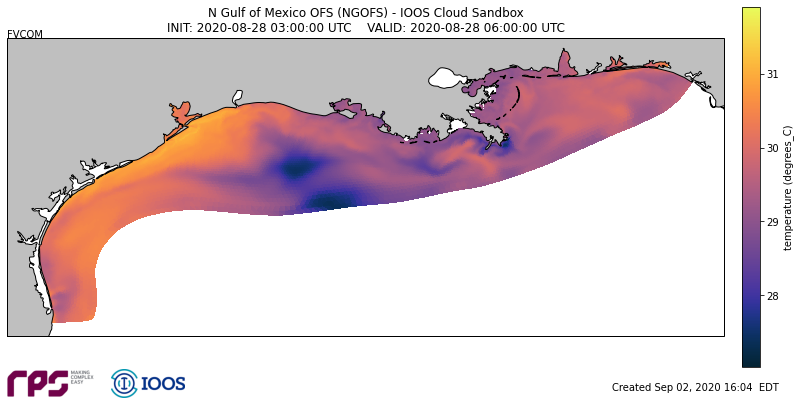

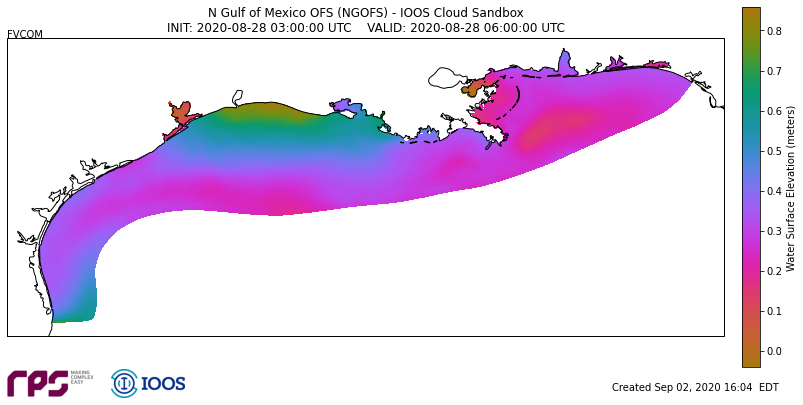

In [314]:
main()
#testing()

In [ ]:
from cloudflow.workflows import flows

flows.inject_notebook()